In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset                    146KB  2023-10-05 06:45:37           9555        213  1.0              
nelgiriyewithana/top-spotify-songs-2023                     Most Streamed Spotify Songs 2023                     47KB  2023-08-26 11:04:57          38701       1113  1.0              
nelgiriyewithana/billionaires-statistics-dataset            Billionaires Statistics Dataset (2023)              139KB  2023-09-29 13:39:28           5058        132  1.0              
nelgiriyewithana/credit-card-fraud-detection-d

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
! unzip face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join
import pandas as pd
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_dir = os.path.join("/content/Face Mask Dataset", 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,batch_size=32,image_size=(224, 224),shuffle=True)

Found 10000 files belonging to 2 classes.


In [ ]:
# validation dataset
validation_dir = os.path.join("/content/Face Mask Dataset", 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,batch_size=32,image_size=(224,224),shuffle=True)

Found 800 files belonging to 2 classes.


In [ ]:
# test dataset
test_dir = os.path.join("/content/Face Mask Dataset", 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,batch_size=32,image_size=(224,224),shuffle=False)

Found 992 files belonging to 2 classes.


In [ ]:
#Check the Class Names in The Train dataset
class_labels = train_ds.class_names
print(class_labels)

['WithMask', 'WithoutMask']


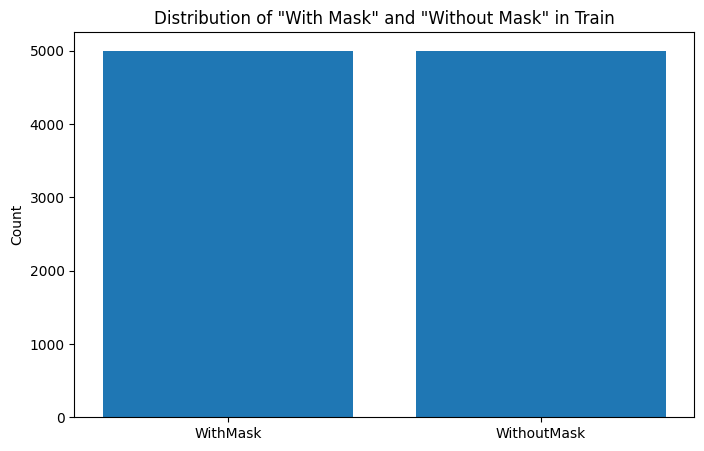

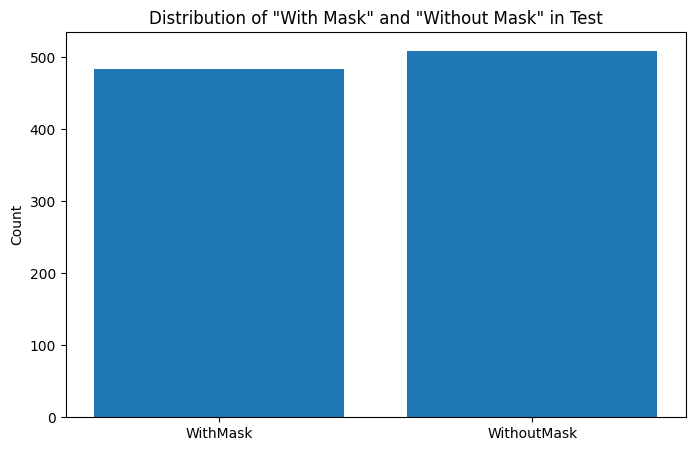

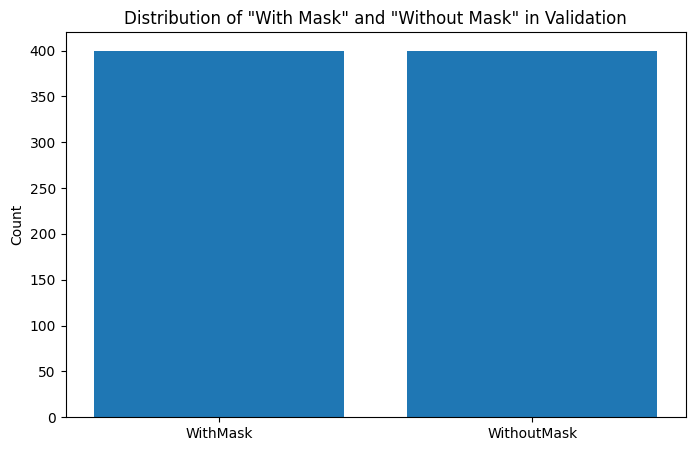

In [ ]:
for dataset, dataset_name in zip([train_ds, test_ds, validation_ds], ['Train', 'Test', 'Validation']):
    with_mask_count = 0
    without_mask_count = 0

    for images, labels in dataset:
        with_mask_count += tf.reduce_sum(tf.where(labels == 0, 1, 0))
        without_mask_count += tf.reduce_sum(tf.where(labels == 1, 1, 0))

    # Plot the distribution
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, [with_mask_count, without_mask_count])
    plt.title(f'Distribution of "With Mask" and "Without Mask" in {dataset_name}')
    plt.ylabel('Count')
    plt.show()

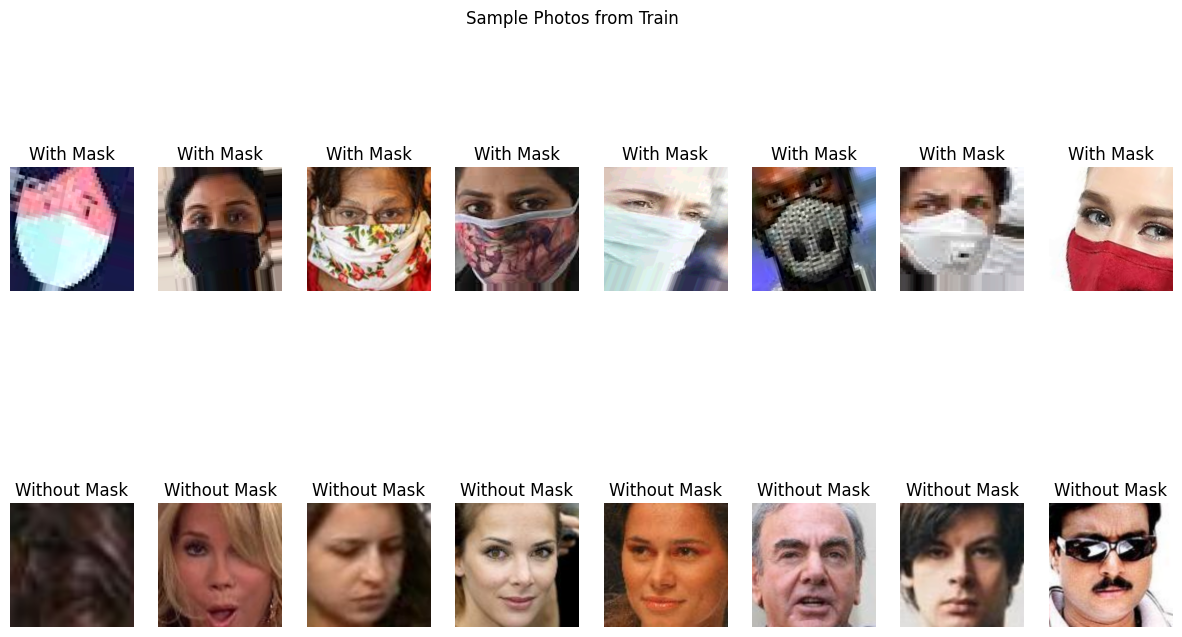

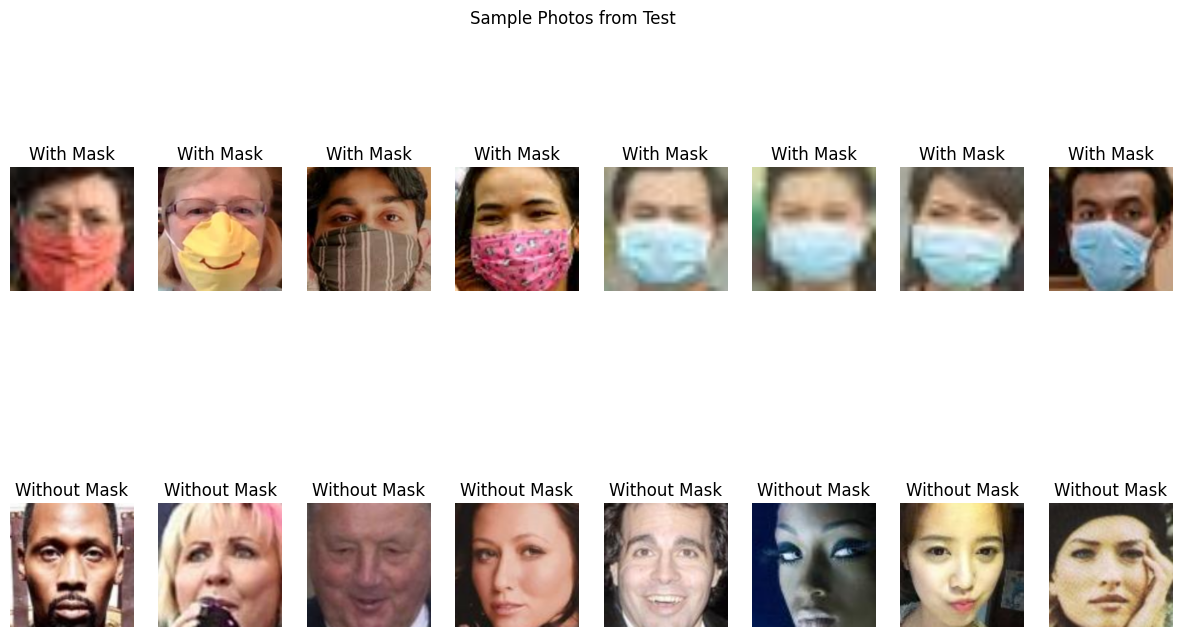

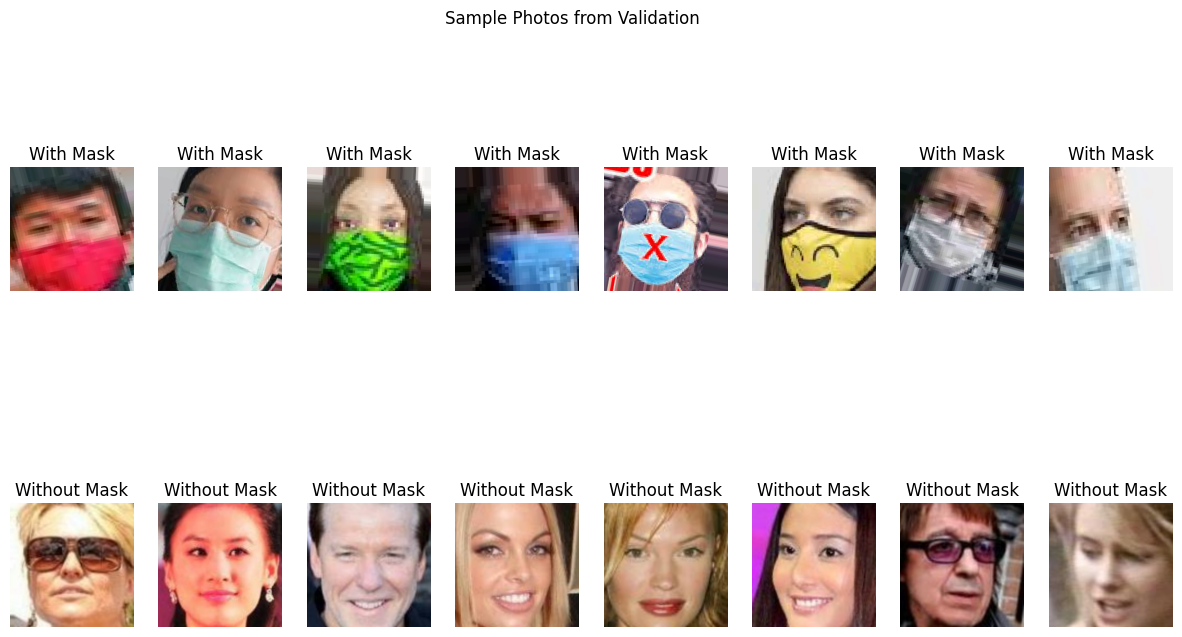

In [ ]:
# Display sample photos
sample_count = 8  # Adjust as needed
for dataset, dataset_name in zip([train_ds, test_ds, validation_ds], ['Train', 'Test', 'Validation']):
    with_mask_images = []
    without_mask_images = []

    for images, labels in dataset:
        for i, label in enumerate(labels):
            if label == 0:
                with_mask_images.append(images[i])
            else:
                without_mask_images.append(images[i])
            if len(with_mask_images) >= sample_count and len(without_mask_images) >= sample_count:
                break

    # Display sample photos
    plt.figure(figsize=(15, 8))
    for i in range(sample_count):
        plt.subplot(2, sample_count, i + 1)
        plt.imshow(with_mask_images[i].numpy().astype("uint8"))
        plt.title("With Mask")
        plt.axis("off")

        plt.subplot(2, sample_count, i + 1 + sample_count)
        plt.imshow(without_mask_images[i].numpy().astype("uint8"))
        plt.title("Without Mask")
        plt.axis("off")

    plt.suptitle(f'Sample Photos from {dataset_name}')
    plt.show()

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same',input_shape=(244, 244, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #128x128
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same',input_shape=(244, 244, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #64x64
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same',input_shape=(244, 244, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #32x32
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same',input_shape=(244, 244, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #16x16
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
# defining callback function to avoid overfitting and wait for N epochs before it stops
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 6, restore_best_weights = True, verbose=1)

In [ ]:
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=40,
  callbacks =[earlystopping],
)

Epoch 1/40
313/313 [==============================] - 22s 65ms/step - loss: 0.1457 - accuracy: 0.9446 - val_loss: 0.0863 - val_accuracy: 0.9787
Epoch 2/40
313/313 [==============================] - 20s 63ms/step - loss: 0.0744 - accuracy: 0.9766 - val_loss: 0.0506 - val_accuracy: 0.9837
Epoch 3/40
313/313 [==============================] - 21s 65ms/step - loss: 0.0475 - accuracy: 0.9825 - val_loss: 0.0490 - val_accuracy: 0.9862
Epoch 4/40
313/313 [==============================] - 21s 66ms/step - loss: 0.0371 - accuracy: 0.9871 - val_loss: 0.0277 - val_accuracy: 0.9900
Epoch 5/40
313/313 [==============================] - 20s 62ms/step - loss: 0.0245 - accuracy: 0.9915 - val_loss: 0.0297 - val_accuracy: 0.9912
Epoch 6/40
313/313 [==============================] - 20s 65ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0485 - val_accuracy: 0.9862
Epoch 7/40
313/313 [==============================] - 22s 68ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.0200 - val_accuracy:

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

31/31 [==============================] - 1s 37ms/step - loss: 0.0403 - accuracy: 0.9909
Test accuracy: 0.9909


In [ ]:
# Get model predictions on the test data
y_pred_prob = model.predict(test_ds)

# Convert predicted probabilities to class labels (0 or 1)
y_pred = np.argmax(y_pred_prob, axis=1)

31/31 [==============================] - 1s 37ms/step


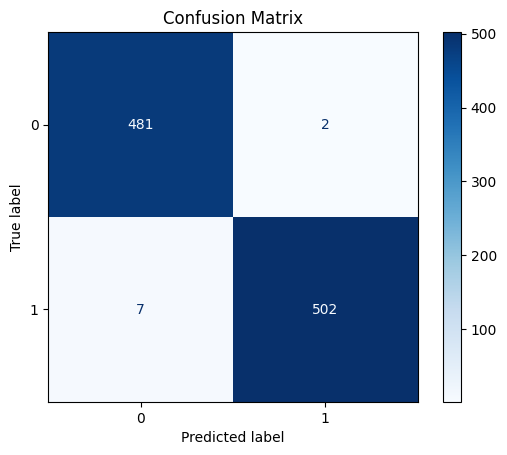

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get true labels from the test dataset
y_true = np.array([label for _, label in test_ds.unbatch()])

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
labels = [0, 1]  # Your class labels
cm_display = ConfusionMatrixDisplay(confusion, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save("face_mask_detection_model.h5")

In [ ]:
model = tf.keras.models.load_model("/content/face_mask_detection_model.h5")

In [ ]:
test_image = image.load_img('/content/images.jpeg', target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize pixel values

In [ ]:
predictions = model.predict(test_image)

1/1 [==============================] - 0s 95ms/step


In [ ]:
if predictions[0][0] >= predictions[0][1]:
    print("The person is not wearing a mask")
else:
    print("The person is wearing a mask")

The person is wearing a mask


In [ ]:
np.set_printoptions(suppress=True)
print(predictions)

[[0.96842986 0.03699312]]


In [ ]:
test_image = image.load_img('/content/Untitled.jpeg', target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize pixel values

In [ ]:
predictions = model.predict(test_image)

1/1 [==============================] - 0s 35ms/step


In [ ]:
if predictions[0][0] > predictions[0][1]:
    print("The person is wearing a mask")
else:
    print("The person is not wearing a mask")

The person is wearing a mask


In [ ]:
print(predictions)

[[0.9701155 0.0337338]]
